## Instructions
- See deadline on the course web page
- This problem set is performed individually.See examination rules on the course web page.
- Students are allowed to discuss together and help each other when solving the problems. However, every student must understand and be able to explain his/her submitted solution. Plagiarism is not allowed (submissions will be both manually and automatically monitored).
- The two notebooks for each problem set contain a number of basic and extra problems; you can choose which and how many to work on.
- Many problems are automatically graded using `assert` statements. You should check that your code passes these statements without raising an `AssertionError`. Note that there might be additional, hidden tests that must be passed for full credit. In addition, some tasks are either completely manually graded or part-automatic/part-manual.
- Note that grading is performed in the teacher's python environment, which is based on the conda `environment.yml` file in the course github repo. Please avoid using additional python modules (such as `plotly`) as this might cause automatic tests to fail.

- **Important:** Hand-in is performed through the following actions:
  - Make sure to always complete **Task 0** in the header part of the notebook. 
  - Upload your solution in the form of your edited version of this jupyter notebook via the appropriate module in Canvas.
  - The name of the uploaded file **must be the same as the original one**!
  
  Note that the hand-in might not be automatically graded if you have changed the name of the uploaded file.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

- Make sure that the **run time is smaller than a few minutes**. If needed you might have to reduce some computational tasks; e.g. by decreasing the number of grid points or sampling steps. Please ask the supervisors if you are uncertain about the run time. 

- Your solutions are usually expected where it says `YOUR CODE HERE` or <font color="red">"PLEASE WRITE YOUR ANSWER HERE"</font>.

### Task 0 
#### (0 points)
Fill your personal details in the dictionary 'student' with the following key/value pairs:
- **Lastname**: Your lastname as a string
- **Firstname**: Your firstname as a string
- **DOB-year**: The year for your date of birth as a four-digit integer
- **DOB-month**: The month for your date of birth as an integer (1-12)
- **DOB-day**: The year for your date of birth as an integer (1-31)
- **CID**: Your Chalmers login ID as a string

In [1]:
student={}
# Update the values below. Note the formats.
student['Lastname']='Brundin'  # string
student['Firstname']='Isak' # string
student['CID']='isakbr'        # string
student['DOB-year']=1997         # four-digit integer
student['DOB-month']=9          # integer in the range [1, 12]
student['DOB-day']=23             # integer in the range [1, 31]

# 
# YOUR CODE HERE
# 

In [2]:
for key in ['Lastname', 'Firstname','CID']:
    assert type(student[key]) is str, f'{key} is wrong type.'
    assert student[key] not in ['name_here','cid_here'],\
        f'Fill your {key} as a string.'

for key in ['DOB-year', 'DOB-month','DOB-day']:
    assert type(student[key]) is int, f'{key} is wrong type.'

assert (student['DOB-year'] > 1900 and student['DOB-year'] < 2100)
assert student['DOB-month'] in range(1,13), \
    'DOB month should be an integer in the range [1, 12]'
assert student['DOB-day'] in range(1,32), \
    'DOB day should be an integer in the range [1, 31]'

# Problem Set 1
## Extra problems
### Learning from data [TIF285], Chalmers, Fall 2021

Last revised: 29-Aug-2021 by Christian Forssén [christian.forssen@chalmers.se]

In [3]:
# import modules


import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import emcee

## Problem 5 (extra)
### (3 points)

#### Reload the third dataset from Problem 3

In [ ]:
datafile = 'DataFiles/dataset3.dat'
X, y = np.loadtxt(datafile, unpack=True)
m = len(X)
X = X.reshape(m,1); y = y.reshape(m,1)

#### Validation curves
Create a validation curve for the polynomial model (for different degrees) where you plot the training score and the validation score as a function of the model complexity. 
- The model complexity is simply the degree of the polynomial.
- Make sure to print (e.g. in the axis label) what "score" that is shown (remember that there are different measures being used in the literature).
- For the computation of training and validation scores you are encouraged to use cross-validation which is more stable than the use of a single, random pair of training and validation sets.

Question to ponder:
- From this curve: Which order polynomial do you think was used when generating the data?

*Hint:* `scikit-learn` has a function `validation_curve` that might be useful. It is instructive to implement the calculation of learning curves yourself, but it is not required for this task.

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
range = np.logspace(0,1,len(X))
print(y.shape)
train_scores, valid_scores = validation_curve(skl.linear_model.Ridge(), X, y,param_name='alpha',param_range=range, cv = 10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
print(train_scores.shape)
plt.semilogx(range,train_scores_mean)
plt.semilogx(range,test_scores_mean)
plt.semilogx(range,np.abs(-train_scores_mean+test_scores_mean))

## Problem 6 (extra)
### (3 points)

### Gradient descent methods

#### Generate noisy data with a quadratic feature
This is the same data as in Problem 2.

In [72]:
# Generate noisy data with a quadratic feature
# use the following code:
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 0.5 * X**2 + X + 2 + 0.2 * np.random.randn(100, 1)

#### (a) Batch and stochastic gradient descent
Implement both batch and stochastic gradient descent and use these methods to find the best fit parameters of a quadratic model.
- You might want to tune the learning hyperparameter $\eta$.
- Do 50 epochs for the SGD (each epoch corresponding to using all instances of data once)
- Compare with the solution from Problem 2.

In [108]:
def design_matrix(X, degree=2):
    m = X.shape[0]
    X_d = np.zeros((m, degree+1))
    for i in range(m):
        for j in range(degree+1):
            X_d[i,j] = X[i]**j
    return X_d

def solve_normal_equation(X_d, y):
    X_t = np.transpose(X_d)
    X_inv = np.linalg.inv(np.matmul(X_t,X_d))
    theta_best = np.matmul(X_inv, X_t).dot(y).flatten()
    return theta_best

def linear_regression(X, y, degree=2):
    X_mat = design_matrix(X,degree)
    theta = solve_normal_equation(X_mat,y)
    return theta
def cost_function(y,X,theta):
    n = X.shape(1)
    C = 1/n*np.dot(np.transpose((y-np.dot(X,theta))),(y-np.dot(X,theta)))
    return C
def der_cost_function(y,X,theta, n = len(y)):
    dC = -2/n*np.dot(np.transpose(X),(y-np.dot(X,theta)))
    return dC
def BGD(theta,y,X,neta = 0.02, n = len(y)):
    return theta - neta*der_cost_function(y,X,theta,n)

def SGD(theta,y,x,n,neta = 0.02):
    return theta - neta*der_cost_function(y,X,theta)

In [109]:
# Implement BGD and use it to find the best-fit parameters
#
# At the end, the following array should contain the 
# best-fit parameters: 
# theta_0 (constant term), theta_1 (linear), theta_2 (quadratic)
theta_bgd = np.array([0., 0., 0.]) # Note the order
m = len(y)
X_mat = design_matrix(X)
for i in range(200):
    theta_bgd = BGD(theta_bgd.reshape(3,1),y,X_mat,0.02).flatten()
theta_bgd

array([1.98754072, 0.92378984, 0.54927   ])

In [127]:
# Implement SGD and use it to find the best-fit parameters
#
# At the end, the following array should contain the 
# best-fit parameters: 
# theta_0 (constant term), theta_1 (linear), theta_2 (quadratic)
import random
y_new = np.copy(y)
X_mat = design_matrix(X)
X_new = np.copy(X_mat)
theta_sgd = np.array([0., 0., 0.]) # Note the order
batch_size = len(y_new)
epochs = 500
for j in range(epochs):
    y_new = np.copy(y)
    X_mat = design_matrix(X)
    X_new = np.copy(X_mat)
    for i in range(batch_size):
        randint = random.randint(0,len(y_new)-1)
        temp_y = np.array(y_new[randint])
        y_new = np.append(y_new[0:randint],y_new[randint+1:])
        temp_x = X_mat[randint,:]
        X_mat = np.vstack((X_mat[0:randint,:],X_mat[randint+1:,:]))
        theta_sgd = BGD(theta_sgd.reshape(3,1),temp_y, temp_x.reshape(1,3),n=batch_size).flatten()


theta_sgd
        
# 
# YOUR CODE HERE
# 

array([2.05374157, 0.89358969, 0.53635835])

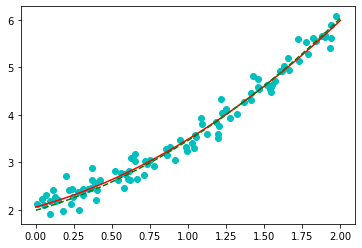

In [128]:
plt.plot(X,y,'co')
x = np.linspace(0,2,100)
y_sgd = theta_sgd[0]+x*theta_sgd[1]+x**2*theta_sgd[2]
plt.plot(x,y_sgd,'r-')
y_bgd = theta_bgd[0]+x*theta_bgd[1]+x**2*theta_bgd[2]
plt.plot(x,y_bgd,'g--')

In [129]:
assert theta_bgd.shape ==(3,)
assert not (theta_bgd==0).any()
assert theta_sgd.shape ==(3,)
assert not (theta_sgd==0).any()


#### (b) Mini-batch gradient descent
Implement mini-batch gradient descent and use this method to find the best fit parameters. Details:
- use a mini-batch size of 20%
- perform 50 epochs 
- hint: the `numpy.random.permutation` function might be useful for creating the mini-batches. 
- Compare with the solutions from BGD and SGD.

In [ ]:
# Implement MBGD and use it to find the best-fit parameters
#
# At the end, the following array should contain the 
# best-fit parameters: 
# theta_0 (constant term), theta_1 (linear), theta_2 (quadratic)
theta_mbgd = np.array([0., 0., 0.]) # Note the order

# 
# YOUR CODE HERE
# 

In [ ]:
assert theta_mbgd.shape ==(3,)
assert not (theta_mbgd==0).any()


#### (c) Convergence
Compare the convergence pattern for the BGD, SGD and MGD, i.e. plot the path towards the optimal set of parameters. 
- Note that the path is in 3D (since there are three parameters in our quadratic model). You can plot 2D projections of the path.

In [ ]:
# 
# YOUR CODE HERE
# 